Beim Umweltbundesamt gibt es PM10 Tagesmittelwerte für Berlin-Mitte https://www.umweltbundesamt.de/daten/luftbelastung/aktuelle-luftdaten#/stations?s=rY6xjsIwEET/ZWsXdsAhlxKREukKJApEsZdbwDrHRvYGiij/zlpIpyuQaE5bzY5m5k0wEOYxuXDeICO0EzB+QQv9mBIFBgUcoTXWGrOwttYKTikO8lk2i6qyVaVnBZmRXQy5xHNMLPmAA0n4Qu58Ed2srIJr9H5kDMX/3Botfu7jlUSa3XZftpyk2jB6ryAQ32P6EXPdwe+GyE237nTdyO8bmQrc8kNO64LSY5mfwDENwnOYXgbfk/yp1qu6VP9D0xPyqAB7djf5ntBnmucH&_k=du4ocz


In [1]:
from dask import dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = '../data/'

# Import, Clean and Merge of Sensor Data
(taken from http://localhost:8888/notebooks/jupyter/BTW.ipynb)

In [2]:
df_sds011 = dd.read_csv(path + 'processed*sds011*').compute()
df_dht22 = dd.read_csv(path + 'processed*dht22*').compute()

df_sds011['timestamp'] = pd.to_datetime(df_sds011['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_dht22['timestamp'] = pd.to_datetime(df_dht22['timestamp'], format='%Y-%m-%dT%H:%M:%S')

df_sds011 = df_sds011.set_index(['location', 'timestamp'])
df_dht22 = df_dht22.set_index(['location', 'timestamp'])

df_sds011 = df_sds011.sort_index()
df_dht22 = df_dht22.sort_index()

df_sds011 = df_sds011[['P1', 'P2']]
df_dht22 = df_dht22[['temperature', 'humidity']]

In [3]:
def resample(df, freq='60min'):
    level_values = df.index.get_level_values
    return df.groupby([level_values(0)] + [pd.Grouper(freq=freq, level=1)]).mean().dropna()

def remove_outlier(df):
    res = df[np.abs(df - df.mean()) <= (3*df.std())]
    return res.dropna()

df_sds011 = remove_outlier(df_sds011)
df_dht22 = remove_outlier(df_dht22)

df_sds011 = resample(df_sds011)
df_dht22 = resample(df_dht22)

In [4]:
data = pd.merge(df_sds011, df_dht22, left_index=True, right_index=True, how='inner')
data = data[data.humidity <= 70.0]


# Merge into one location and group by day

In [5]:
data = data.reset_index(level='location')
del data['location']
grouped = data.groupby(level = ['timestamp'])
data['Sensor P1_mean'] = grouped['P1'].transform('mean')

In [6]:
data = data.resample('D').mean()

# Load uba data

In [7]:
uba = dd.read_csv('../uba/data_2019_02_25.csv', sep=';').compute()
uba['timestamp'] = pd.to_datetime(uba['Zeit'])

In [8]:
#	Stationscode	Stationsname	Netzwerk	Schadstoff	Datentyp	Zeit
#	DEBE068	Berlin Mitte	BE	Feinstaub (PM10)	Tagesmittel (1TMW)
uba = uba[['timestamp', 'Messwert']].set_index('timestamp')
uba = uba.rename(columns={'Messwert':'UBA P1'})


In [27]:
uba_ours = pd.merge(data['Sensor P1_mean'], uba, left_index=True, right_index=True, how='inner')


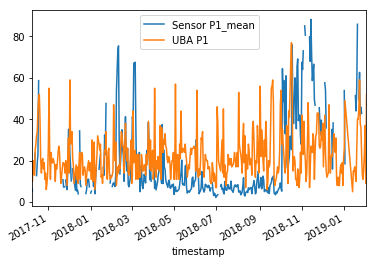

In [28]:
uba_ours.plot()

In [29]:
uba_ours.corr()

,Sensor P1_mean,UBA P1
Sensor P1_mean,1.000000,0.168892
UBA P1,0.168892,1.000000


# Konklusion, ToDo
* 'gewünschtes' Ergebnis nicht erreicht. 
* Trauen wir den Sensoren nicht oder den offiziellen Messwerten
* sind die Sensoren einfach zu lokal spezifisch, würde eine Auswertung aller Sensoren aus Berlin helfen? 
* Welche Analysemöglichkeiten gibt es für Zeitreihen noch, jenseits von einfacher Korrelation?